## Nodebooks: Introducing Node.js Data Science Notebooks

Notebooks (that’s Jupyter/IPython Notebooks, not Moleskine® notebooks) are where data scientists process, analyse, and visualise data in an iterative, collaborative environment. Like other developers, I am not a data scientist, but I do like the idea of having a scratchpad where I can write some code, iteratively work on some algorithms, and visualise the results quickly.
To that end, David Taieb and I created pixiedust_node, an add-on for Jupyter notebooks that allows Node.js/JavaScript to run inside notebook cells. It’s built on the popular PixieDust helper library. So let’s get started!


## Part 1: Variables, functions, and promises


### Installing
Install the [`pixiedust`](https://pypi.python.org/pypi/pixiedust) and [`pixiedust_node`](https://pypi.python.org/pypi/pixiedust-node) packages using `pip`, the Python package manager. 

In [ ]:
!pip install pixiedust
!pip install pixiedust_node

### Using pixiedust_node
Now we can import `pixiedust_node` into our notebook:

In [2]:
import pixiedust_node

Pixiedust database opened successfully


And then we can write JavaScript code in cells whose first line is `%%node`:

In [3]:
%%node
var date = new Date();
print(date);

pixiedust_node 0.1.4 started. Cells starting '%%node' may contain Node.js code.
"2018-02-07T21:20:27.731Z"


It’s that easy! We can have Python and Node.js in the same notebook. Cells are Python by default, but simply starting a cell with `%%node` indicates that the next lines will be JavaScript.

### Printing JavaScript variables
Calling the `print` function within your JavaScript code is the same as calling `print` in your Python code.

In [4]:
%%node
var x = { a:1, b:'two', c: true };
print(x);

{"a": 1, "c": true, "b": "two"}


### Visualizing data
You can also use PixieDust’s `display` function to render data graphically.


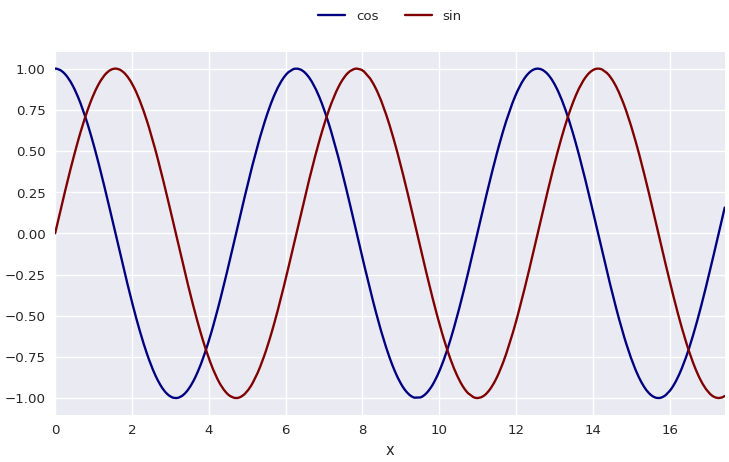

In [5]:
%%node
var data = [];
for (var i = 0; i < 1000; i++) {
    var x = 2*Math.PI * i/ 360;
    var obj = {
      x: x,
      i: i,
      sin: Math.sin(x),
      cos: Math.cos(x),
      tan: Math.tan(x)
    };
    data.push(obj);
}
// render data 
display(data);

PixieDust presents visualisations of data frames using Matplotlib, Bokeh, Brunel, d3, Google Maps and, MapBox. No code is required on your part because PixieDust presents simple pull-down menus and a friendly point-and-click interface, allowing you to configure how the data is presented:

### Adding npm modules
There are thousands of libraries and tools in the npm repository, Node.js’s package manager. It’s essential that we can install npm libraries and use them in our notebook code.
Let’s say we want to make some HTTP calls to an external API service. We could deal with Node.js’s low-level HTTP library, or an easier option would be to use the ubiquitous `request` npm module.
Once we have pixiedust_node set up, installing an npm module is as simple as running `npm.install` in a Python cell:

In [6]:
npm.install('request');

/Users/patti/anaconda/bin/npm install -s request
/Users/patti/pixiedust/node
└─┬ silverlining@1.24.5
└── request@2.83.0


Once installed, you may `require` the module in your JavaScript code:

In [7]:
%%node
var request = require('request');
var r = {
    method:'GET',
    url: 'http://api.open-notify.org/iss-now.json',
    json: true
};
request(r, function(err, req, body) {
    print(body);
});
// {"timestamp": 1494857069, "message": "success", "iss_position": {"latitude": "24.0980", "longitude": "-84.5517"}}

... ... ... ...
... ...
{"timestamp": 1518038436, "message": "success", "iss_position": {"latitude": "-4.7442", "longitude": "-158.5675"}}


As an HTTP request is an asynchronous action, the `request` library calls our callback function when the operation has completed. Inside that function, we can call print to render the data.
We can organise our code into functions to encapsulate complexity and make it easier to reuse code. We can create a function to get the current position of the International Space Station in one notebook cell:

In [8]:
%%node
var request = require('request');
var getPosition = function(callback) {
    var r = {
        method:'GET',
        url: 'http://api.open-notify.org/iss-now.json',
        json: true
    };
    request(r, function(err, req, body) {
        var obj = null;
        if (!err) {
            obj = body.iss_position
            obj.latitude = parseFloat(obj.latitude);
            obj.longitude = parseFloat(obj.longitude);
            obj.time = new Date().getTime();       
        }
        callback(err, obj);
    });
};

... ..... ..... ..... ..... ... ..... ..... ....... ....... ....... ....... ....... ..... ..... ...


And use it in another cell:

In [9]:
%%node
getPosition(function(err, data) {
    print(data);
});

... ...
{"latitude": -4.7442, "longitude": -158.5675, "time": 1518038443184}


### Promises
If you prefer to work with JavaScript Promises when writing asynchronous code, then that’s okay too. Let’s rewrite our `getPosition` function to return a Promise. First we're going to install the `request-promise` module from npm:

In [10]:
npm.install( ('request', 'request-promise') )

/Users/patti/anaconda/bin/npm install -s request request-promise
/Users/patti/pixiedust/node
├── request-promise@4.2.2
└─┬ silverlining@1.24.5
└── request@2.83.0


Notice how you can install multiple modules in a single call. Just pass in a Python `list` or `tuple`.
Then we can refactor our function a little:

In [11]:
%%node
var request = require('request-promise');
var getPosition = function(callback) {
    var r = {
        method:'GET',
        url: 'http://api.open-notify.org/iss-now.json',
        json: true
    };
    return request(r).then(function(body) {
        var obj = null;
        obj = body.iss_position;
        obj.latitude = parseFloat(obj.latitude);
        obj.longitude = parseFloat(obj.longitude);
        obj.time = new Date().getTime();         
        return obj;
    });
};

... ..... ..... ..... ..... ... ..... ..... ..... ..... ..... ..... ..... ...


And call it in the Promises style:

In [33]:
%%node
getPosition().then(function(data) {
  print(data);
}).catch(function(err) {
  print(err);    
});

... ... ... ...
{"latitude": 24.5329, "longitude": -6.0458, "time": 1518040820765}


Or call it in a more compact form:

In [34]:
%%node
getPosition().then(print).catch(print);


{"latitude": 24.0569, "longitude": -5.6023, "time": 1518040829323}


***
## Part 2: Working with data sources

To access data stored in an Apache CouchDB or Cloudant database, we can use the [`cloudant-quickstart`](https://www.npmjs.com/package/cloudant-quickstart) npm module:


In [16]:
npm.install('cloudant-quickstart')

/Users/patti/anaconda/bin/npm install -s cloudant-quickstart
/Users/patti/pixiedust/node
└─┬ cloudant-quickstart@1.25.1
└── qrate@1.0.2


With our Cloudant URL, we can start exploring the data in Node.js. First we make a connection to the remote Cloudant database:

In [28]:
%%node
// connect to Cloudant using cloudant-quickstart
var cqs = require('cloudant-quickstart');
var cities = cqs('https://reader.cloudant.com/cities');

Now we have an object cities that we can use to access the database. 

### Exploring the data using Node.js in a notebook 

If we know the IDs of documents, we can retrieve them singly:

In [29]:
%%node
cities.get('2636749').then(print).catch(print);

{"name": "Stowmarket", "country": "GB", "longitude": 0.99774, "latitude": 52.18893, "timezone": "Europe/London", "_id": "2636749", "population": 15394}


Or in bulk:

In [20]:
%%node
cities.get(['4562407','2636749','3530597']).then(print).catch(print);

[{"name": "York", "country": "US", "longitude": -76.72774, "latitude": 39.9626, "timezone": "America/New_York", "_id": "4562407", "population": 43718}, {"name": "Stowmarket", "country": "GB", "longitude": 0.99774, "latitude": 52.18893, "timezone": "Europe/London", "_id": "2636749", "population": 15394}, {"name": "Mexico City", "country": "MX", "longitude": -99.12766, "latitude": 19.42847, "timezone": "America/Mexico_City", "_id": "3530597", "population": 12294193}]


Instead of just calling `print` to output the JSON, we can bring PixieDust's `display` function to bear by passing it an array of data to visualize:

In [21]:
%%node
cities.get(['4562407','2636749','3530597']).then(display).catch(print);

We can also query a subset of the data using the `query` function, passing it a Cloudant Query statement:

In [27]:
%%node
// fetch cities in UK above latitude 54 degrees north
cities.query({country:'GB', latitude: { "$gt": 54}}).then(display).catch(print);

### Aggregating data
The `cloudant-quickstart` library also allows aggregations (sum, count, stats) to be performed in the Cloudant database.
Let’s calculate the sum of the population field:

In [25]:
%%node
cities.sum('population').then(print).catch(print);

{"ok": false, "statusCode": 401}


Or compute the sum of the `population`, grouped by the `country` field:

In [26]:
%%node
cities.sum('population','country').then(print).catch(print);

{"ok": false, "statusCode": 401}


***
## Part 3: Sharing data between Python and Node.js cells

to be continued ...

#### References:
 * [Nodebooks: Introducing Node.js Data Science Notebooks](https://medium.com/ibm-watson-data-lab/nodebooks-node-js-data-science-notebooks-aa140bea21ba)
 * [Nodebooks: Sharing Data Between Node.js & Python](https://medium.com/ibm-watson-data-lab/nodebooks-sharing-data-between-node-js-python-3a4acae27a02)
 * [Sharing Variables Between Python & Node.js in Jupyter Notebooks](https://medium.com/ibm-watson-data-lab/sharing-variables-between-python-node-js-in-jupyter-notebooks-682a79d4bdd9)